/home/maria/CrimeStats/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Daily crime matrix shape: (633, 27)


/home/maria/CrimeStats/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


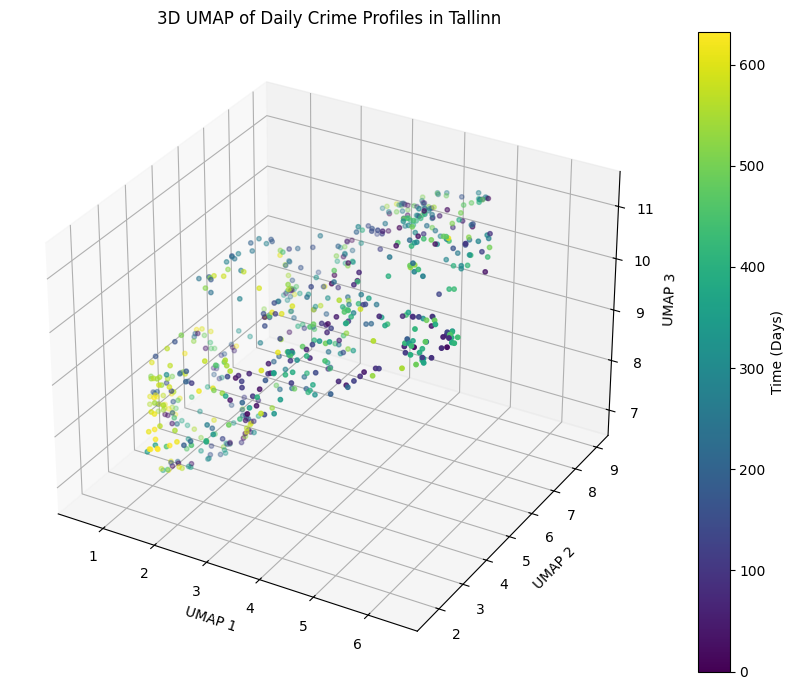

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# ─────────────────────────────────────────────────────
# Step 1: Load and parse data
# ─────────────────────────────────────────────────────

dat = pd.read_csv('/home/maria/CrimeStats/data/avalik_1.csv', sep='\t')
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])
tallinn.set_index('ToimDatetime', inplace=True)

# ─────────────────────────────────────────────────────
# Step 2: Clean crime type and count per day
# ─────────────────────────────────────────────────────

tallinn['CrimeType'] = tallinn['SyndmusLiik'].astype(str).apply(lambda x: x.split(',')[0])
daily_matrix = tallinn.groupby([tallinn.index.date, 'CrimeType']).size().unstack(fill_value=0)
daily_matrix.index = pd.to_datetime(daily_matrix.index)
daily_matrix = daily_matrix.sort_index()

print("Daily crime matrix shape:", daily_matrix.shape)

# ─────────────────────────────────────────────────────
# Step 3: UMAP to 3D
# ─────────────────────────────────────────────────────

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(daily_matrix.values)

# ─────────────────────────────────────────────────────
# Step 4: Plot in 3D
# ─────────────────────────────────────────────────────

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding_3d[:, 0],
                     embedding_3d[:, 1],
                     embedding_3d[:, 2],
                     c=np.arange(len(embedding_3d)),
                     cmap='viridis',
                     s=10)

ax.set_title("3D UMAP of Daily Crime Profiles in Tallinn")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

plt.colorbar(scatter, label='Time (Days)')
plt.tight_layout()
plt.show()


/home/maria/CrimeStats/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved 3D rotation animation to 'tallinn_crime_umap_rotation.mp4'


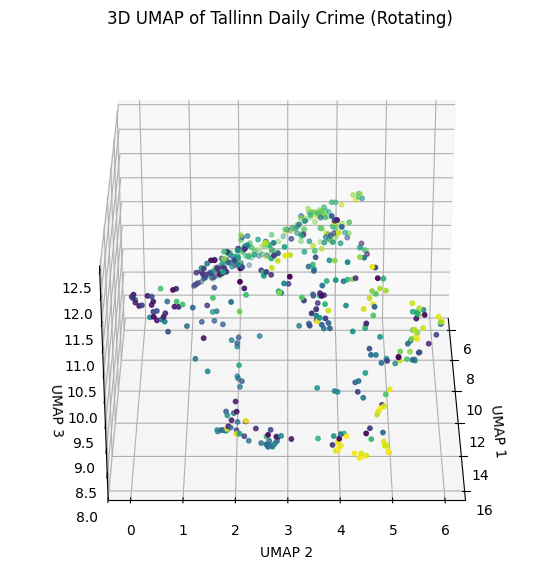

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import umap
from mpl_toolkits.mplot3d import Axes3D

# ─────────────────────────────────────────────────────
# Load and prepare data (same as before)
# ─────────────────────────────────────────────────────

dat = pd.read_csv('/home/maria/CrimeStats/data/avalik_1(1).csv', sep='\t')
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])
tallinn.set_index('ToimDatetime', inplace=True)

tallinn['CrimeType'] = tallinn['SyndmusLiik'].astype(str).apply(lambda x: x.split(',')[0])
daily_matrix = tallinn.groupby([tallinn.index.date, 'CrimeType']).size().unstack(fill_value=0)
daily_matrix.index = pd.to_datetime(daily_matrix.index)
daily_matrix = daily_matrix.sort_index()

# ─────────────────────────────────────────────────────
# UMAP Embedding
# ─────────────────────────────────────────────────────

reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=8)
embedding_3d = reducer.fit_transform(daily_matrix.values)

# ─────────────────────────────────────────────────────
# Create rotating 3D plot
# ─────────────────────────────────────────────────────

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = np.linspace(0, 1, len(embedding_3d))
scatter = ax.scatter(embedding_3d[:, 0],
                     embedding_3d[:, 1],
                     embedding_3d[:, 2],
                     c=colors,
                     cmap='viridis',
                     s=10)

ax.set_title("3D UMAP of Tallinn Daily Crime (Rotating)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

# Rotation function
def update(angle):
    ax.view_init(elev=30, azim=angle)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)

# Save the animation
ani.save("tallinn_crime_umap_rotation.mp4", writer="ffmpeg", fps=20)
# Optional: Save as GIF
# ani.save("tallinn_crime_umap_rotation.gif", writer="pillow", fps=20)

print("✅ Saved 3D rotation animation to 'tallinn_crime_umap_rotation.mp4'")
